# Transition Path

In this notebook, I solve and simulate the housing model along a **transition path** stemming from an interest rate shock

In [4]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import funcs as f
from scipy import stats

# load the DurableConsumptionModel module
from HousingModel import HousingModelClass

# Set the number of threads in numba
nb.set_num_threads(3)

# Smoother
from scipy.signal import savgol_filter

In [5]:
# Something for figure layout here
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

# Plot a partial equilibrium transition path

In [6]:
# Initialize model and solve initial steady state
model1 = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model1.precompile_numba()
model1.solve()
model1.simulate() # simulate initial ss

# For convenience
par = model1.par
sim = model1.sim
sim1 = model1.sim_path

In [4]:
model1.solve_path()
model1.simulate_path()

In [5]:
# Connect the points
IRF_c_raw = np.zeros(400)
IRF_a_raw = np.zeros(400)
IRF_d_raw = np.zeros(400)
IRF_discrete_raw = np.zeros(400)

# Add ss part
IRF_c_raw[:200] = np.mean(model1.sim.c,axis=1)
IRF_a_raw[:200] = np.mean(model1.sim.a,axis=1)
IRF_d_raw[:200] = np.mean(model1.sim.d,axis=1)
IRF_discrete_raw[:200] = np.mean(model1.sim.discrete,axis=1)

# Add shock part
IRF_c_raw[200:] = np.mean(model1.sim_path.c,axis=1)
IRF_a_raw[200:] = np.mean(model1.sim_path.a,axis=1)
IRF_d_raw[200:] = np.mean(model1.sim_path.d,axis=1)
IRF_discrete_raw[200:] = np.mean(model1.sim_path.discrete,axis=1)

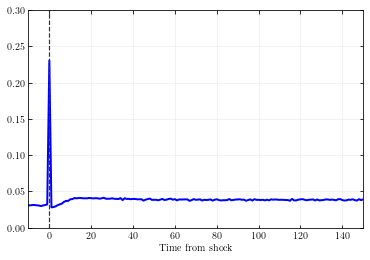

In [8]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(range(-200,200),IRF_discrete_raw, color = 'blue', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,150)
ax.set_ylim(0,.3)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')
 
ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_discrete_raw.pdf')

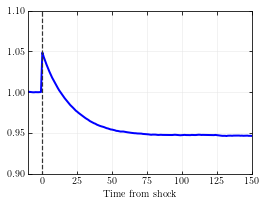

In [14]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(-200,200),IRF_c_raw/IRF_c_raw[199], color = 'blue', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,150)
ax.set_ylim(.9,1.1)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_c_raw.pdf')

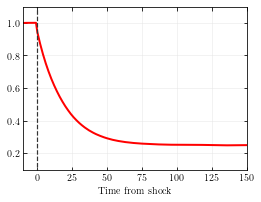

In [15]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(-200,200),IRF_a_raw/IRF_a_raw[199], color = 'red', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,150)
ax.set_ylim(.1,1.1)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_a_raw.pdf')

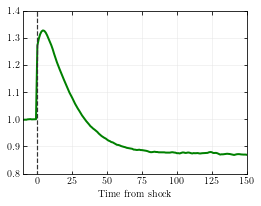

In [18]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(-200,200),IRF_d_raw/IRF_d_raw[199], color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)

# ax.plot(range(-200,200),IRF_d_raw, color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)

ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,150)
ax.set_ylim(.8,1.4)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_d_raw.pdf')

In [24]:
del model1

# Find Equilibrium Along a Transition Path

I apply a relaxation algorithm where I use a ghost run along the path as the benchmark to update equilibrium prices

## Baseline Case Without Taxes

### Define model

In [23]:
# Initialize model and solve initial steady state
model1 = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})
model1.precompile_numba()
model1.solve()
model1.simulate() # simulate initial ss

# For convenience
par = model1.par
sim = model1.sim
sim1 = model1.sim_path

### Simulate ghost run

In [25]:
model1.par.R_drop = 0.0
model1.solve_path()
model1.simulate_path()
H_ghost1 = np.mean(model1.sim_path.d, axis=1)

Plot ghost run to see how it looks

### Reset interest rate drop

In [29]:
model1.par.R_drop = 0.01
model1.par.path_ph[:] = 1.0

### Run algorithm

In [1]:
# a. allocate
path_ph = np.zeros(par.path_T + par.T)

# b. setting - 0.9999
nu = 0.1 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
# path_ph[:] = par.ph
model1.par.path_ph[:] = model1.par.ph # Set to steady state

# d. Iterate
it = 0
for _ in range(max_iter):

    # ii. Solve and simulate
    model1.solve_path()
    model1.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model1.sim_path.d, axis=1)
    
    # iv. Difference
    max_abs_diff = np.max(np.abs(H - H_ghost1)) # remove last 50 periods?
    
    if max_abs_diff < 10e-3: break # test different values of this threshold

    # v. Update prices
    model1.par.path_ph[0:model1.par.path_T] = model1.par.path_ph[0:model1.par.path_T] + .1*(H-H_ghost1)
    model1.par.path_ph[model1.par.path_T:] = model1.par.path_ph[model1.par.path_T-1]
    
    # vi.  Increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')

### Plot the Impulse Responses

Define path of aggregates, so that it starts 10 periods before the shock

In [23]:
p_path_base = np.zeros(10+model1.par.path_T)
p_path_base[0:10] = model1.par.ph
p_path_base[10:] = model1.par.path_ph[0:model1.par.path_T] / model1.par.ph

c_path_base = np.zeros(10+model1.par.path_T)
c_path_base[0:10] = np.mean(model1.sim.c, axis=1)[-10:] / np.mean(model1.sim.c, axis=1)[-1:]
c_path_base[10:] = np.mean(model1.sim_path.c, axis=1)/ np.mean(model1.sim.c, axis=1)[-1:]

a_path_base = np.zeros(10+model1.par.path_T)
a_path_base[0:10] = np.mean(model1.sim.a, axis=1)[-10:] / np.mean(model1.sim.a, axis=1)[-1:]
a_path_base[10:] = np.mean(model1.sim_path.a, axis=1) / np.mean(model1.sim.a, axis=1)[-1:]

t_axis = range(-10,200) # Time from shock

#### Equilibrium housing price

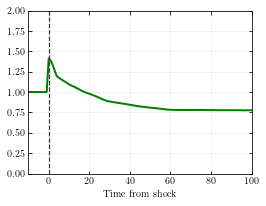

In [268]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, p_path_base, color = 'green', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
# ax.set_ylim(6.98,7.53)
# ax.set_ylim(0.6,1.5)
ax.set_ylim(0,2)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_ph.pdf')

#### Non-durable consumption

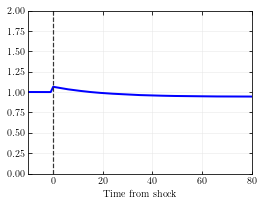

In [269]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, c_path_base, color = 'blue', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,80)
# ax.set_ylim(0.4,1.6)
ax.set_ylim(0,2)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/IRF_c.pdf')

#### Cash on hand

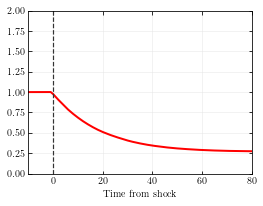

In [270]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, a_path_base, color = 'red', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,80)
# ax.set_ylim(0,1.6)
ax.set_ylim(0,2)

ax.set_xlabel('Time from shock')
ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_m.pdf')

### Compute other statistics along the transition path

Variance of wealth distribution

In [47]:
par1 = model1.par
sim1 = model1.sim
sim_path1 = model1.sim_path

In [50]:
# Generate path of wealth
w = np.zeros(shape=(par1.path_T+10,par1.simN))

for k in range(-10,par1.T):
    
    t = k + 10
    if k < 0:
        w[t] = (sim1.m[k] + par1.ph*sim1.n[k]) / sim1.y[k]

    else:
        w[t] = (sim_path1.m[k] + par1.path_ph[k]*sim_path1.n[k]) / sim_path1.y[k]

In [63]:
# mean_var = np.var(w,axis=1) / np.mean(w,axis=1)
gini = np.zeros(50)
for t in range(0,50):
    gini[t] = f.gini(w[t,:])

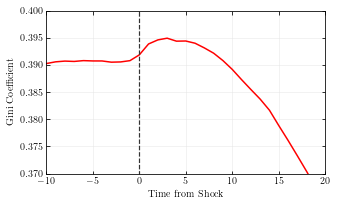

In [92]:
# Initialize the figure
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(range(-10,40),gini, color = 'red', linestyle = '-')
ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

# Plot setting
ax.set_xlabel('Time from Shock')
ax.set_ylabel('Gini Coefficient')

ax.set_xlim(-10,20)
ax.set_ylim(0.37,.4)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend()

plt.savefig('../../tex/figs/gini.pdf')

#### Binned scatterplots

Compute gain from $t=0$ to $t=1$

In [57]:
gain = (par.path_ph[0]*model1.sim_path.n[0,:] - par.ph*model1.sim.d[-1,:]) / (model1.sim_path.m[0,:] + model1.sim_path.n[0,:])

In [58]:
# try binned scatterplot
gains_means, bin_edges, binnumber = stats.binned_statistic(model1.sim.m[-1,:],gain, bins=np.linspace(0,10,11), statistic = 'mean')

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

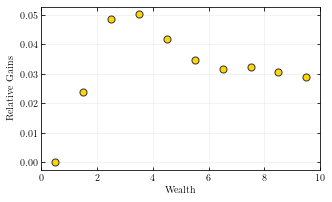

In [93]:
# Initialize the figure
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.scatter(bin_centers, gains_means, s=50, c='gold', marker='o', edgecolors = '0.2', zorder=2) 
# ax.plot(par.grid_m,y_fit)

# Plot setting
ax.set_xlabel('Wealth')
ax.set_ylabel('Relative Gains')

ax.set_xlim(0,10)
# ax.set_ylim(0.4,.55)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
# ax.legend()

plt.savefig('../../tex/figs/gains_bins.pdf')

Housing demand

In [391]:
# try binned scatterplot
n_init, bin_edges, binnumber = stats.binned_statistic(model1.sim.m[-1,:],model1.sim_path.n[0,:], bins=np.linspace(0,10,11), statistic = 'mean')

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_init = bin_edges[1:] - bin_width/2

In [410]:
# try binned scatterplot
n_term, bin_edges, binnumber = stats.binned_statistic(model1.sim_path.m[150,:],model1.sim_path.n[150,:], bins=np.linspace(0,10,11), statistic = 'mean')

# Compute bins
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers_term = bin_edges[1:] - bin_width/2

# Transition path with avancebeskatning

Define model

In [7]:
# Set parameters
taug = 0.02 # Avancebeskatnings rate
Npb = 50

# Initialize model and solve initial steady state
model2 = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'taug':taug, 'Npb':Npb, 'do_print':False})
model2.precompile_numba()
model2.solve()
model2.simulate() # simulate initial ss

In [171]:
# iii. Implied aggregate housing demand
H = np.mean(model2.sim_path.d, axis=1)

In [96]:
# Remove interest rate drop
model2.par.R_drop = 0.0

# Solve and simulate
model2.solve_path()
model2.simulate_path()
H_ghost2 = np.mean(model2.sim_path.d, axis=1)

Reset interest rate drop

In [51]:
model2.par.R_drop = 0.01

In [2]:
# a. allocate
path_ph = np.zeros(model2.par.path_T + model2.par.T)

# b. setting - 0.9999
nu = 0.6 # relaxation parameter
max_iter = 1000 # maximum number of iterations

# # c. Set path of prices
# path_ph[:] = model2.par.ph
# model2.par.path_ph[:] = model2.par.ph # Set to steady state

# d. iterate
it = 0
for _ in range(max_iter):

    # ii. solve and simulate
    model2.solve_path()
    model2.simulate_path()

    # iii. Implied aggregate housing demand
    H = np.mean(model2.sim_path.d, axis=1)
    
    # iv. difference
    max_abs_diff = np.max(np.abs(H[:-50] - H_ghost2[:-50]))
    
    # if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 10e-3: break # test different values of this threshold

    # v. update
    model2.par.path_ph[0:model2.par.path_T] = model2.par.path_ph[0:model2.par.path_T] + nu*(H-H_ghost2)
    model2.par.path_ph[model2.par.path_T:] = model2.par.path_ph[model2.par.path_T-1]
        
    # vi. increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    

In [21]:
p_path_g = np.zeros(10+model2.par.path_T)
p_path_g[0:10] = model2.par.ph
p_path_g[10:] = model2.par.path_ph[0:model2.par.path_T] / model2.par.ph

c_path_g = np.zeros(10+model2.par.path_T)
c_path_g[0:10] = np.mean(model2.sim.c, axis=1)[-10:] / np.mean(model2.sim.c[-1])
c_path_g[10:] = np.mean(model2.sim_path.c, axis=1) / np.mean(model2.sim.c[-1])

a_path_g = np.zeros(10+model2.par.path_T)
a_path_g[0:10] = np.mean(model2.sim.a, axis=1)[-10:] / np.mean(model2.sim.a[-1])
a_path_g[10:] = np.mean(model2.sim_path.a, axis=1) / np.mean(model2.sim.a[-1])

t_axis = range(-10,200) # Time from shock

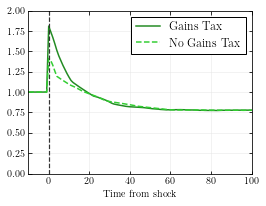

In [25]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, p_path_g, color = 'forestgreen', linestyle='-', linewidth=1.5,  zorder=2, label = r'Gains Tax')
ax.plot(t_axis, p_path_base, color = 'limegreen', linestyle='--', linewidth=1.5,zorder=2, label = r'No Gains Tax')

# ax.plot(t_axis, p_path_base, color = 'blue', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)

ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
# ax.set_ylim(0.4,2.0)
ax.set_ylim(0,2.0)

ax.set_xlabel('Time from shock')
# ax.set_ylabel('Relative To SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False, prop={'size': 12})

plt.savefig('../../tex/figs/IRF_ph_taug.pdf')

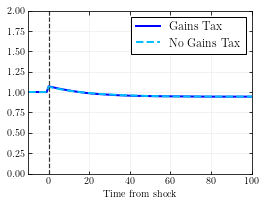

In [266]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, c_path_g, color = 'blue', linestyle='-', linewidth=2,zorder=2, label = r'Gains Tax')
ax.plot(t_axis, c_path_base, color = 'deepskyblue', linestyle='--', linewidth=2,zorder=2, label = r'No Gains Tax')

ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
# ax.set_ylim(0.9,1.2)
ax.set_ylim(0,2)

ax.set_xlabel('Time from shock')
# ax.set_ylabel(r'\% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False, prop={'size': 12})

plt.savefig('../../tex/figs/IRF_c_taug.pdf')

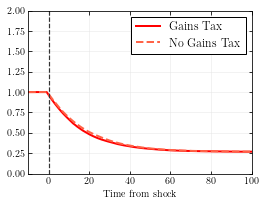

In [271]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis, a_path_g, color = 'red', linestyle='-', linewidth=2, zorder=2, label = r'Gains Tax' )
ax.plot(t_axis, a_path_base, color = 'tomato', linestyle='--', linewidth=2, zorder=2, label = r'No Gains Tax')

ax.vlines(0,0,10, color = '0.2', linestyle='--', linewidth = 1.2, zorder=2)

ax.set_xlim(-10,100)
ax.set_ylim(0,2)
# ax.set_ylim(0.99,1.02)

ax.set_xlabel('Time from shock')
# ax.set_ylabel(r'$p_t$')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False, prop={'size': 12})

plt.savefig('../../tex/figs/IRF_m_taug.pdf')

Plot pb

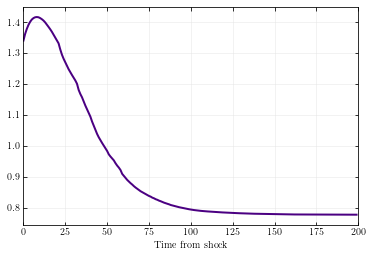

In [204]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(t_axis[10:], np.mean(model2.sim_path.pb, axis=1), color = 'indigo', linestyle='-', linewidth=2,  label = 'Demand',zorder=2)
# ax.plot(t_axis[10:], p_path_g[10:], color = 'blue', linestyle='-', linewidth=1,  label = 'Demand',zorder=2)

ax.set_xlim(0,200)
# ax.set_ylim(.9,1.1)

ax.set_xlabel('Time from shock')
# ax.set_ylabel(r'% Deviation From SS')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/IRF_pb_taug.pdf')

Plot distribution of housing before and after shock

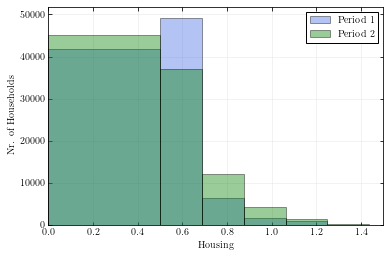

In [505]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.hist(model2.sim_path.n[0,:], model2.par.grid_n, density = False, facecolor='royalblue', edgecolor = 'k', zorder=2, alpha = .4, label = r'Period 1')
ax.hist(model2.sim_path.n[1,:], model2.par.grid_n, density = False, facecolor='green', edgecolor = 'k', zorder=2, alpha = .4, label = r'Period 2')

# Plot setting
ax.set_xlabel('Housing')
ax.set_ylabel('Nr. of Households')

ax.set_xlim(0,1.5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False,  prop={'size': 10})

plt.savefig('../../tex/figs/h_distr_period12.pdf')